# Unsequa - a module for uncertainty and sensitivity analysis

This is a tutorial for the unsequa module in CLIMADA. A detailled description can be found in [Kropf (2021)](https://eartharxiv.org/repository/view/3123/).

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Uncertainty-and-sensitivity-analysis?" data-toc-modified-id="Uncertainty-and-sensitivity-analysis?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Uncertainty and sensitivity analysis?</a></span></li><li><span><a href="#Unsequa-Module-Structure" data-toc-modified-id="Unsequa-Module-Structure-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Unsequa Module Structure</a></span></li><li><span><a href="#InputVar" data-toc-modified-id="InputVar-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>InputVar</a></span><ul class="toc-item"><li><span><a href="#Example---custom-continuous-uncertainty-parameter" data-toc-modified-id="Example---custom-continuous-uncertainty-parameter-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Example - custom continuous uncertainty parameter</a></span></li><li><span><a href="#Example---custom-categorical-uncertainty-parameter" data-toc-modified-id="Example---custom-categorical-uncertainty-parameter-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Example - custom categorical uncertainty parameter</a></span></li></ul></li><li><span><a href="#UncOutput" data-toc-modified-id="UncOutput-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>UncOutput</a></span><ul class="toc-item"><li><span><a href="#Example-from-file" data-toc-modified-id="Example-from-file-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Example from file</a></span></li></ul></li><li><span><a href="#CalcImpact" data-toc-modified-id="CalcImpact-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>CalcImpact</a></span><ul class="toc-item"><li><span><a href="#Set-the-InputVars" data-toc-modified-id="Set-the-InputVars-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Set the InputVars</a></span></li><li><span><a href="#Compute-uncertainty-and-sensitivity-using-default-methods" data-toc-modified-id="Compute-uncertainty-and-sensitivity-using-default-methods-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Compute uncertainty and sensitivity using default methods</a></span></li><li><span><a href="#A-few-non-default-parameters" data-toc-modified-id="A-few-non-default-parameters-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>A few non-default parameters</a></span></li></ul></li><li><span><a href="#CalcCostBenefit" data-toc-modified-id="CalcCostBenefit-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>CalcCostBenefit</a></span><ul class="toc-item"><li><span><a href="#Set-the-InputVars" data-toc-modified-id="Set-the-InputVars-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Set the InputVars</a></span></li><li><span><a href="#Compute-cost-benefit-uncertainty-and-sensitivity-using-default-methods" data-toc-modified-id="Compute-cost-benefit-uncertainty-and-sensitivity-using-default-methods-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Compute cost benefit uncertainty and sensitivity using default methods</a></span></li></ul></li></ul></div>

## Uncertainty and sensitivity analysis?

Before doing an uncertainty quantification in CLIMADA, it is imperative that you get first comfortable with the different notions of uncertainty in the modelling world (see e.g.[Pianosi (2016)](https://www.sciencedirect.com/science/article/pii/S1364815216300287) or [Douglas-Smith(2020)](https://doi.org/10.1007/978-1-4899-7547-8_5) for a review). In particular, note that the uncertaintity values will only be as good as the input from the user. In addition, not all uncertainties can be numerically quantified, and even worse, some unkonwns are unknown. This means that sometimes, quantifying uncertainty can lead to false confidence in the output!. For a more philosophical discussion about the types of uncertainties in climate research see [Knüsel (2020)](https://www.research-collection.ethz.ch/handle/20.500.11850/399735) and [Otth (2022)]().

In this module, it is possible to perform global uncertainty analysis, as well as a sensitivity analysis. The word global is meant as opposition to the 'one-factor-at-a-time' (OAT) strategy. The OAT strategy, which consists in analyzing the effect of varying one model input factor at a time while keeping all other fixed, is popular among modellers, but has major shortcomings [Saltelli (2010)](https://www.sciencedirect.com/science/article/abs/pii/S1364815210001180), [Saltelli(2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822) and should not be used.

A rough schemata of how to perform uncertainty and sensitivity analysis (taken from [Kropf(2021)](https://eartharxiv.org/repository/view/3123/))

<img src="./img/UncertaintySensitivity.jpg" alt="Uncertainty and Sensitivity analysis" width="1000">

1. [Kropf, C.M. et al. Uncertainty and sensitivity analysis for global probabilistic weather and climate risk modelling: an implementation in the CLIMADA platform (2021)](https://eartharxiv.org/repository/view/3123/)
2. [Pianosi, F. et al. Sensitivity analysis of environmental models: A systematic review with practical workflow. Environmental Modelling & Software 79, 214–232 (2016)](https://www.sciencedirect.com/science/article/pii/S1364815216300287).
3.[Douglas-Smith, D., Iwanaga, T., Croke, B. F. W. & Jakeman, A. J. Certain trends in uncertainty and sensitivity analysis: An overview of software tools and techniques. Environmental Modelling & Software 124, 104588 (2020)](https://doi.org/10.1007/978-1-4899-7547-8_5)
4. [Knüsel, B. Epistemological Issues in Data-Driven Modeling in Climate Research. (ETH Zurich, 2020)](https://www.research-collection.ethz.ch/handle/20.500.11850/399735)
5. [Saltelli, A. et al. Why so many published sensitivity analyses are false: A systematic review of sensitivity analysis practices. Environmental Modelling & Software 114, 29–39 (2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822)
6. [Saltelli, A. & Annoni, P. How to avoid a perfunctory sensitivity analysis. Environmental Modelling & Software 25, 1508–1517 (2010)](https://www.sciencedirect.com/science/article/abs/pii/S1364815210001180)

##  Unsequa Module Structure

The unsequa module contains several key classes. 

The model input parameters and their distribution are specified as
- `InputVar`: defines input uncertainty variables

The input parameter sampling, Monte-Carlo uncertainty distribution calculation and the sensitivity index computation are done in
- `CalcImpact`: compute uncertainties for outputs of `climada.engine.impact.calc` (child class of `Calc`)
- `CalcCostBenefit`: compute uncertainties for outputs of `climada.engine.cost_benefit.calc` (child class of `Calc`)

The results are stored in
- `UncOutput`: store the uncertainty and sensitivity analysis results. Contains also several plotting methods. This is a class which only stores data.
- `UncImpactOutput`: subclass with dataframes specifically for `climada.engine.impact.calc` uncertainty and sensitivity analysis results.
- `UncCostBenefitOutput`: subclass with dataframes specifically for `climada.engine.cost_benefit.calc` uncertainty and sensitivity analysis results.

## InputVar 

The InputVar class is used to define uncertainty variables. 

| Attribute | Type | Description |
| --- | --- | --- |
| func | function | Model variable defined as a function of the uncertainty input parameters |
| distr_dict | dict | Dictionary of the probability density distributions of the uncertainty input parameters |

An **input uncertainty parameter** is a numerical input value that has a certain probability density distribution in your model, such as the total exposure asset value, the slope of the vulnerability function, the exponents of the litpop exposure,  the value of the discount rate, the cost of an adaptation measure, ... 

The probability densitity distributions (values of `distr_dict`) of the input uncertainty parameters (keyword arguments of the `func` and keys of the `distr_dict`) can be any of the ones defined in [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html).

 **Several helper methods exist to make generic InputVar for Exposures, ImpactFuncSet, Hazard, Entity (including DiscRates and Measures)**. These are described in details in the tutorial [Helper methods for InputVar](climada_engine_unsequa_helper.ipynb). These are a good bases for your own computations.

### Example - custom continuous uncertainty parameter

Suppose we assume that the GDP value used to scale the exposure has a relative error of +-10%. 

In [1]:
import warnings
warnings.filterwarnings('ignore') #Ignore warnings for making the tutorial's pdf. 

#Define the base exposure
from climada.util.constants import EXP_DEMO_H5
from climada.entity import Exposures
exp_base = Exposures.from_hdf5(EXP_DEMO_H5)

2022-01-10 21:09:45,445 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5


In [2]:
# Define the function that returns an exposure with scaled total assed value
# Here x_exp is the input uncertainty parameter and exp_func the inputvar.func.
def exp_func(x_exp, exp_base=exp_base):
    exp = exp_base.copy()
    exp.gdf.value *= x_exp
    return exp

In [3]:
# Define the Uncertainty Variable with +-10% total asset value
# The probability density distribution of the input uncertainty parameter x_exp is sp.stats.uniform(0.9, 0.2)
from climada.engine.unsequa import InputVar
import scipy as sp

exp_distr = {"x_exp": sp.stats.uniform(0.9, 0.2),
              }
exp_iv = InputVar(exp_func, exp_distr)

In [4]:
# Uncertainty parameters
exp_iv.labels

['x_exp']

In [5]:
# Evaluate for a given value of the uncertainty parameters
exp095 = exp_iv.func(x_exp = 0.95)
print(f"Base value is {exp_base.gdf['value'].sum()}, and the value for x_exp=0.95 is {exp095.gdf['value'].sum()}")

Base value is 657053294559.9105, and the value for x_exp=0.95 is 624200629831.9148


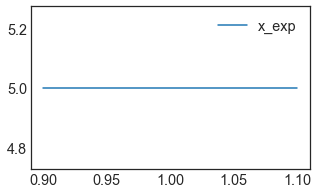

In [6]:
# Defined distribution
exp_iv.plot(figsize=(5, 3));

### Example - custom categorical uncertainty parameter 

Suppose we want to test different exponents (m=1,2 ; n=1,2) for the LitPop exposure for the country Switzerland.

In [7]:
from climada.entity import LitPop

m_min, m_max = (1, 2)
n_min, n_max = (1, 2)

# Define the function
# Note that this here works, but might be slow because the method LitPop is called everytime the the function
# is evaluated, and LitPop is relatively slow. 
def litpop_cat(m, n):
    exp = Litpop.from_countries('CHE', res_arcsec=150, exponent=[m, n])
    return exp

In [9]:
# A faster method would be to first create a dictionnary with all the exposures. This however
# requires more memory and precomputation time (here ~3-4mins)
exp = LitPop()
litpop_dict = {}
for m in range(m_min, m_max + 1):
    for n in range(n_min, n_max + 1):
        exp_mn = LitPop.from_countries('CHE', res_arcsec=150, exponents=[m, n]);
        litpop_dict[(m, n)] = exp_mn
        
def litpop_cat(m, n, litpop_dict=litpop_dict):
    return litpop_dict[(m, n)]

2022-02-11 16:29:34,770 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020


53.1kKB [00:25, 2.07kKB/s]                                                                                                                                                                                      


2022-02-11 16:30:05,073 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2022-02-11 16:30:07,529 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2022-02-11 16:30:10,199 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020


In [10]:
#Define the distribution dictionnary
import scipy as sp
from climada.engine.unsequa import InputVar

distr_dict = {
    'm': sp.stats.randint(low=m_min, high=m_max+1),
    'n': sp.stats.randint(low=n_min, high=n_max+1)
    }

cat_iv = InputVar(litpop_cat, distr_dict) # One can use either of the above definitions of litpop_cat

In [11]:
# Uncertainty parameters
cat_iv.labels

['m', 'n']

2022-01-10 21:09:52,830 - climada.util.coordinates - INFO - Raster from resolution 0.04166666000000063 to 0.04166666000000063.


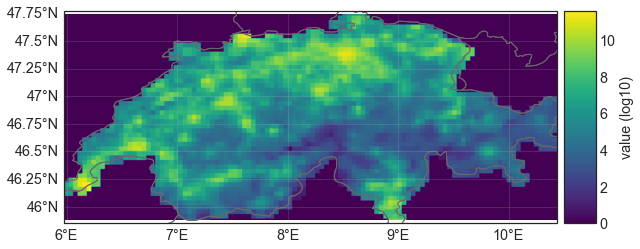

In [12]:
cat_iv.evaluate(m=1, n=2).plot_raster();

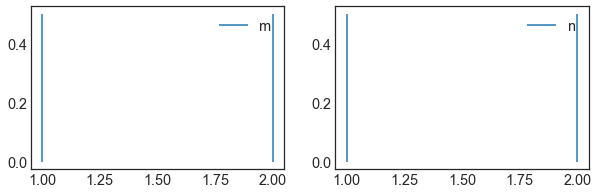

In [13]:
cat_iv.plot(figsize=(10, 3));

## UncOutput 

The `UncOutput` class is used to store data from sampling, uncertainty and sensitivity analysis. An UncOutput object can be saved and loaded from .hdf5. The classes `UncImpactOuput` and `UncCostBenefitOutput` are extensions of `UncOutput` specific for `CalcImpact` and `CalcCostBenefit`, respectively.

**Data attributes**

| Attribute | Type | Description |
| --- | --- | --- |
| samples_df | pandas.dataframe | Each row represents a sample obtained from the input parameters (one per column) distributions |
| | | |
| *UncImpactOutput* | |  |
| | | |
| aai_agg_unc_df | pandas.dataframe | Uncertainty data for `aai_agg`|
| tot_value_unc_df| pandas.dataframe | Uncertainty data for `tot_value`. |
| freq_curve_unc_df | pandas.dataframe | Uncertainty data for `freq_curve`. One return period per column.|
| eai_exp_unc_df | pandas.dataframe | Uncertainty data for `eai_exp`. One exposure point per column.|
| at_event_unc_df | pandas.dataframe | Uncertainty data for `at_event`. One event per column.|
| | | |
| *UncCostBenefitOutput* | |  |
| | | |
| imp_meas_present_unc_df | pandas.dataframe | Uncertainty data for `imp_meas_present`. One measure per column.|
| imp_meas_future_unc_df| pandas.dataframe | Uncertainty data for `imp_meas_present`. One measure per column |
| tot_climate_risk_unc_df | pandas.dataframe | Uncertainty data for `tot_climate_risk`. One measure per column.|
| benefit_unc_df | pandas.dataframe | Uncertainty data for `benefit`. One measure per column.|
| cost_ben_ratio_unc_df | pandas.dataframe | Uncertainty data for `cost_ben_ratio`. One measure per column.|
| cost_benefit_kwargs | dictionary | Keyword arguments for `climada.engine.cost_benefit.calc`. |

**Metadata and input data attributes**

These attributes are used for book-keeping and characterize the sample, uncertainty and sensitivity data. These attributes are set by the methods from classes `CalcImpact` and `CalcCostBenefit` used to generate sample, uncertainty and sensitivity data.

| Attribute | Type | Description |
| --- | --- | --- |
| sampling_method | str | The sampling method as defined in [SALib](https://salib.readthedocs.io/en/latest/api.html). Possible choices: 'saltelli', 'fast_sampler', 'latin', 'morris', 'dgsm', 'ff'|
| sampling_kwargs | dict | Keyword arguments for the sampling_method. |
| n_samples | int | Effective number of samples (number of rows of samples_df)|
| param_labels | list(str) | Name of all the uncertainty input parameters|
| problem_sa | dict | The description of the uncertainty variables and their distribution as used in [SALib](https://salib.readthedocs.io/en/latest/basics.html). |
| sensitivity_method | str | Sensitivity analysis method from [SALib.analyse](https://salib.readthedocs.io/en/latest/api.html) Possible choices: 'fast', 'rbd_fact', 'morris', 'sobol', 'delta', 'ff'. Note that in Salib, sampling methods and sensitivity analysis methods should be used in specific pairs.|
| sensitivity_kwargs | dict | Keyword arguments for sensitivity_method. |
| unit | str | Unit of the exposures value |

### Example from file 

Here we show an example loaded from file. In the sections below this class is extensively used and further examples can be found.

In [15]:
# Download the test file from the API
# Requires internet connection
from climada.util.constants import TEST_UNC_OUTPUT_IMPACT
from climada.util.api_client import Client
apiclient = Client()
ds = apiclient.get_dataset_info(name=TEST_UNC_OUTPUT_IMPACT, status='test_dataset')
_target_dir, [filename] = apiclient.download_dataset(ds)

https://climada.ethz.ch/data-api/v1/dataset	data_type=None	limit=100000	name=test_unc_output_impact	status=test_dataset	version=None


In [16]:
# If you produced your own data, you do not need the API. Just replace 'filename' with the path to your file.
from climada.engine.unsequa import UncOutput
unc_imp = UncOutput.from_hdf5(filename)

2022-07-06 20:49:01,375 - climada.engine.unsequa.unc_output - INFO - Reading /Users/evelynm/climada/data/unc_output/unc_output_impact/test_unc_output_impact/v1/test_unc_output_impact.hdf5


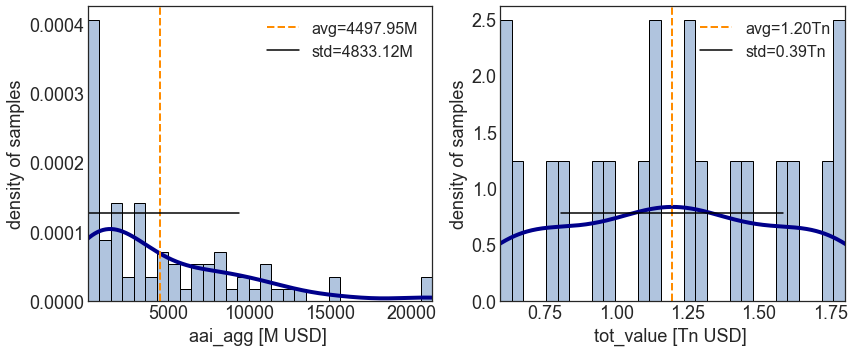

In [17]:
unc_imp.plot_uncertainty(metric_list=['aai_agg', 'tot_value'], figsize=(12,5));

In [18]:
# Download the test file from the API
# Requires internet connection
from climada.util.constants import TEST_UNC_OUTPUT_COSTBEN
from climada.util.api_client import Client
apiclient = Client()
ds = apiclient.get_dataset_info(name=TEST_UNC_OUTPUT_COSTBEN, status='test_dataset')
_target_dir, [filename] = apiclient.download_dataset(ds)

https://climada.ethz.ch/data-api/v1/dataset	data_type=None	limit=100000	name=test_unc_output_costben	status=test_dataset	version=None


In [19]:
# If you produced your own data, you do not need the API. Just replace 'filename' with the path to your file.
from climada.engine.unsequa import UncOutput
unc_cb = UncOutput.from_hdf5(filename)

2022-07-06 20:49:04,789 - climada.engine.unsequa.unc_output - INFO - Reading /Users/evelynm/climada/data/unc_output/unc_output_costben/test_unc_output_costben/v1/test_unc_output_costben.hdf5


In [20]:
unc_cb.get_uncertainty().tail()

,Mangroves Benef,Beach nourishment Benef,Seawall Benef,Building code Benef,Mangroves CostBen,Beach nourishment CostBen,Seawall CostBen,Building code CostBen,no measure - risk - future,no measure - risk_transf - future,...,Beach nourishment - cost_ins - future,Seawall - risk - future,Seawall - risk_transf - future,Seawall - cost_meas - future,Seawall - cost_ins - future,Building code - risk - future,Building code - risk_transf - future,Building code - cost_meas - future,Building code - cost_ins - future,tot_climate_risk
35,2.375510e+08,1.932608e+08,234557.682554,1.584398e+08,6.347120,10.277239,4.350910e+04,66.742129,6.337592e+08,0.0,...,1,6.335246e+08,0,1.020539e+10,1,4.753194e+08,0,1.057461e+10,1,6.337592e+08
36,9.272772e+07,7.643803e+07,9554.257314,5.501366e+07,16.260133,25.984286,1.068151e+06,192.217876,2.200547e+08,0.0,...,1,2.200451e+08,0,1.020539e+10,1,1.650410e+08,0,1.057461e+10,1,2.200547e+08
37,1.464219e+08,1.179927e+08,192531.748810,8.979471e+07,10.297402,16.833137,5.300629e+04,117.764285,3.591788e+08,0.0,...,1,3.589863e+08,0,1.020539e+10,1,2.693841e+08,0,1.057461e+10,1,3.591788e+08
38,9.376369e+07,7.722882e+07,10681.112247,5.555413e+07,12.965484,20.736269,7.703765e+05,153.475031,2.222165e+08,0.0,...,1,2.222058e+08,0,8.228478e+09,1,1.666624e+08,0,8.526172e+09,1,2.222165e+08
39,9.376369e+07,7.722882e+07,10681.112247,5.555413e+07,16.080478,25.718218,9.554617e+05,190.347852,2.222165e+08,0.0,...,1,2.222058e+08,0,1.020539e+10,1,1.666624e+08,0,1.057461e+10,1,2.222165e+08


##  CalcImpact

### Set the InputVars 

In this example, we model the impact function for tropical cyclones on the parametric function suggested in Emanuel (2015) with 4 parameters. The exposures total value varies between 80% and 120%. For that hazard, we assume to have no good error estimate and thus do not define an InputVar for the hazard.

In [1]:
#Define the input variable functions
import numpy as np

from climada.entity import ImpactFunc, ImpactFuncSet, Exposures
from climada.util.constants import EXP_DEMO_H5, HAZ_DEMO_H5
from climada.hazard import Hazard

def impf_func(G=1, v_half=84.7, vmin=25.7, k=3, _id=1):
    
    def xhi(v, v_half, vmin):
        return max([(v - vmin), 0]) / (v_half - vmin)

    def sigmoid_func(v, G, v_half, vmin, k):
        return G * xhi(v, v_half, vmin)**k / (1 + xhi(v, v_half, vmin)**k)

    #In-function imports needed only for parallel computing on Windows
    import numpy as np 
    from climada.entity import ImpactFunc, ImpactFuncSet 
    intensity_unit = 'm/s'
    intensity = np.linspace(0, 150, num=100)
    mdd = np.repeat(1, len(intensity))
    paa = np.array([sigmoid_func(v, G, v_half, vmin, k) for v in intensity])
    imp_fun = ImpactFunc("TC", _id, intensity, mdd, paa, intensity_unit)
    imp_fun.check()
    impf_set = ImpactFuncSet()
    impf_set.append(imp_fun)
    return impf_set



haz = Hazard.from_hdf5(HAZ_DEMO_H5)
exp_base = Exposures.from_hdf5(EXP_DEMO_H5)
#It is a good idea to assign the centroids to the base exposures in order to avoid repeating this
# potentially costly operation for each sample.
exp_base.assign_centroids(haz) 
def exp_base_func(x_exp, exp_base):
    exp = exp_base.copy()
    exp.gdf.value *= x_exp
    return exp
from functools import partial
exp_func = partial(exp_base_func, exp_base=exp_base)

2022-07-06 21:15:51,600 - climada.hazard.base - INFO - Reading /Users/evelynm/climada/demo/data/tc_fl_1990_2004.h5
2022-07-06 21:15:51,643 - climada.entity.exposures.base - INFO - Reading /Users/evelynm/climada/demo/data/exp_demo_today.h5
2022-07-06 21:15:51,714 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2022-07-06 21:15:51,718 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100


2022-07-06 21:15:51,732 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


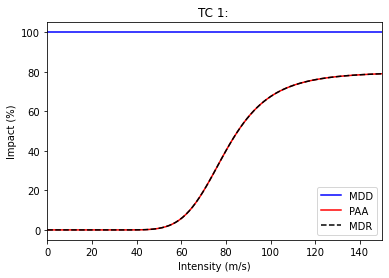

In [2]:
# Visualization of the parametrized impact function
impf_func(G=0.8, v_half=80, vmin=30,k=5).plot();

In [3]:
#Define the InputVars

import scipy as sp
from climada.engine.unsequa import InputVar

exp_distr = {"x_exp": sp.stats.beta(10, 1.1)} #This is not really a reasonable distribution but is used 
                                              #here to show that you can use any scipy distribution.
              
exp_iv = InputVar(exp_func, exp_distr)

impf_distr = {
    "G": sp.stats.truncnorm(0.5, 1.5),
    "v_half": sp.stats.uniform(35, 65),
    "vmin": sp.stats.uniform(0, 15),
    "k": sp.stats.uniform(1, 4)
    }
impf_iv = InputVar(impf_func, impf_distr)

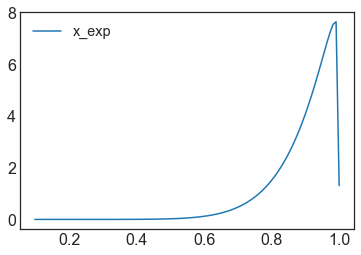

In [4]:
import matplotlib.pyplot as plt
ax = exp_iv.plot(figsize=(6,4));
plt.yticks(fontsize=16);
plt.xticks(fontsize=16);

### Compute uncertainty and sensitivity using default methods 

First, we define the UncImpact object with our uncertainty variables. 

In [5]:
from climada.engine.unsequa import CalcImpact

calc_imp = CalcImpact(exp_iv, impf_iv, haz)

Next, we generate samples for the uncertainty parameters using the default methods. Note that depending on the chosen Salib method, the effective number of samples differs from the input variable N. For the default 'saltelli', with `calc_second_order=True`, the effective number is N(2D+2), with D the number of uncertainty parameters. See [SAlib](https://salib.readthedocs.io/en/latest/api.html) for more information.

In [6]:
output_imp = calc_imp.make_sample(N=2**7, sampling_kwargs={'skip_values': 2**8})
output_imp.get_samples_df().tail()

2022-07-06 21:15:53,716 - climada.engine.unsequa.calc_base - INFO - Effective number of made samples: 1536


,x_exp,G,v_half,vmin,k
1531,0.876684,1.242977,53.662109,2.080078,4.539062
1532,0.876684,0.790617,44.013672,2.080078,4.539062
1533,0.876684,0.790617,53.662109,13.681641,4.539062
1534,0.876684,0.790617,53.662109,2.080078,3.960938
1535,0.876684,0.790617,53.662109,2.080078,4.539062


The resulting samples can be visualized in plots.

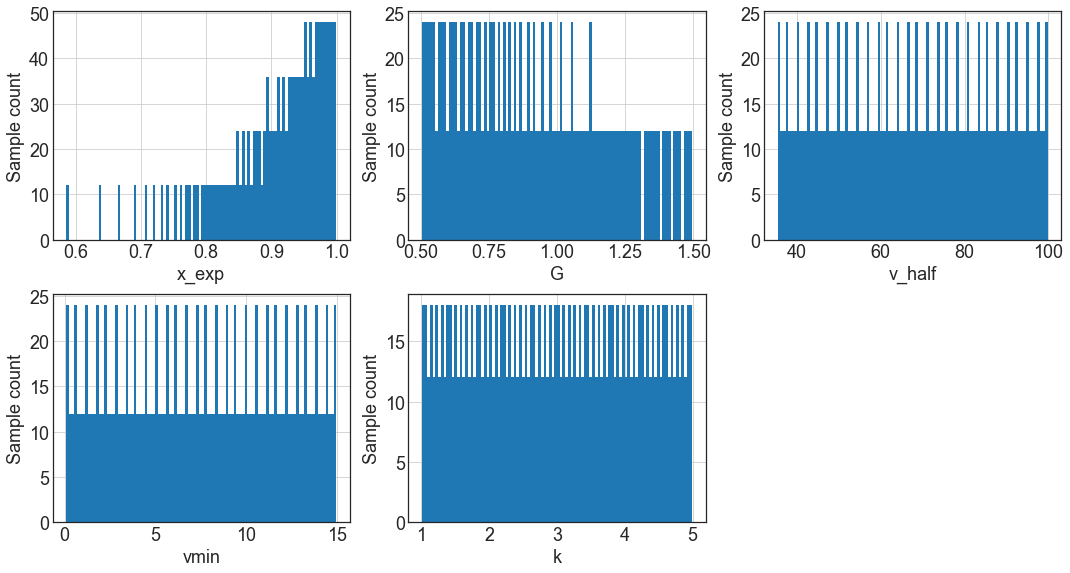

In [7]:
output_imp.plot_sample(figsize=(15,8));

Now we can compute the value of the impact metrics for all the samples. In this example, we additionaly chose to restrict the return periods 50, 100, and 250 years. By default, `eai_exp` and `at_event` are not stored.

In [8]:
output_imp = calc_imp.uncertainty(output_imp, rp = [50, 100, 250])

2022-07-06 21:15:59,535 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:15:59,537 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:15:59,540 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:15:59,545 - climada.engine.unsequa.calc_base - INFO - 

Estimated computaion time: 0:00:25.036800



The distributions of metrics ouputs are stored as dictionaries of pandas dataframe. The metrics are directly taken from the output of `climada.impact.calc`. For each metric, on dataframe is made.

In [9]:
#All the computed uncertainty metrics attribute
output_imp.uncertainty_metrics

['aai_agg', 'freq_curve', 'tot_value']

In [10]:
#One uncertainty dataframe
output_imp.get_unc_df('aai_agg').tail()

,aai_agg
1531,2.905571e+09
1532,3.755172e+09
1533,1.063119e+09
1534,2.248718e+09
1535,1.848139e+09


Accessing the uncertainty is in general done via the method `get_uncertainty()`. If none are specified, all metrics are returned.

In [11]:
output_imp.get_uncertainty().tail()

,aai_agg,rp50,rp100,rp250,tot_value
1531,2.905571e+09,8.324391e+10,1.162643e+11,1.510689e+11,5.760281e+11
1532,3.755172e+09,1.096005e+11,1.460838e+11,1.809413e+11,5.760281e+11
1533,1.063119e+09,2.892734e+10,4.720869e+10,6.807561e+10,5.760281e+11
1534,2.248718e+09,6.468855e+10,8.653474e+10,1.085266e+11,5.760281e+11
1535,1.848139e+09,5.294874e+10,7.395191e+10,9.609003e+10,5.760281e+11


The distributions of the one-dimensioanl metrics (`eai_exp` and `at_event` are never shown with this method) can be vizualised with plots.

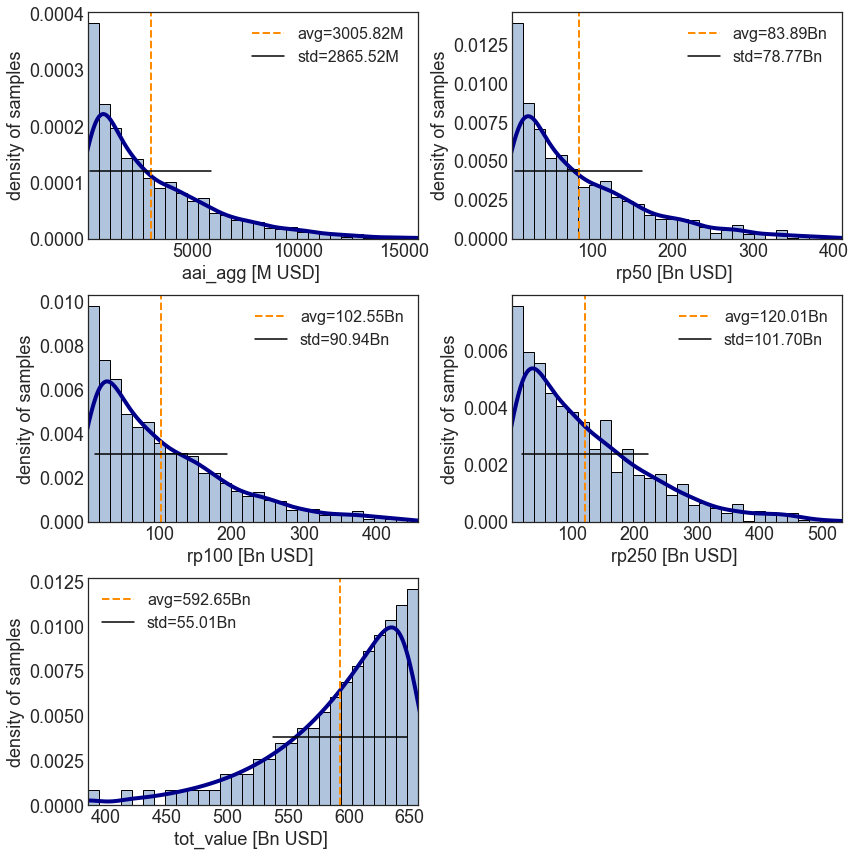

In [12]:
output_imp.plot_uncertainty(figsize=(12,12));

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


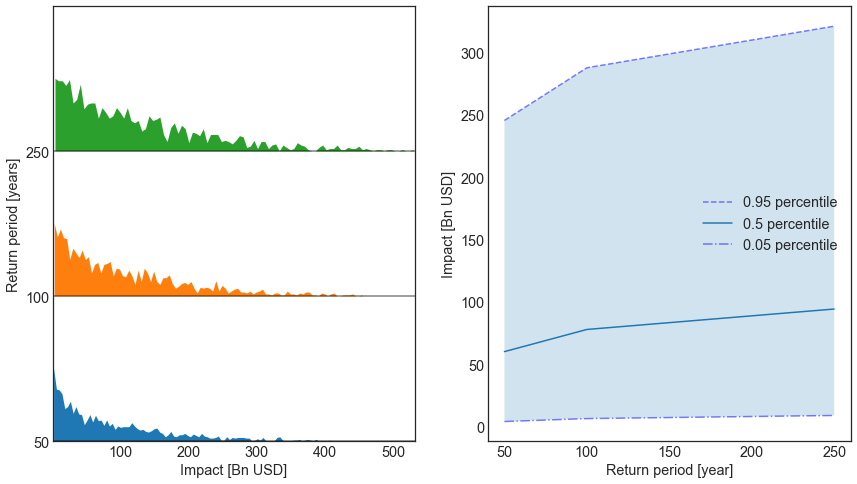

In [13]:
# Specific plot for the return period distributions
output_imp.plot_rp_uncertainty(figsize=(14.3,8));

Now that a distribution of the impact metrics has been computed for each sample, we can also compute the sensitivity indices for each metrics to each uncertainty parameter. Note that the chosen method for the sensitivity analysis should correpond to its sampling partner as defined in the [SAlib](https://salib.readthedocs.io/en/latest/api.html) package.

The sensitivity indices dictionnaries outputs from the SAlib methods are stored in the same structure of nested dictionnaries as the metrics distributions. Note that depending on the chosen sensitivity analysis method the returned indices dictionnary will return specific types of sensitivity indices with specific names. Please get familiar with [SAlib](https://salib.readthedocs.io/en/latest/api.html) for more information.


Note that in our case, several of the second order sensitivity indices are negative. For the default method `sobol`, this indicates that the algorithm has not converged and cannot give realiable values for these sensitivity indices. If this happens, please use a larger number of samples. Here we will focus on the first-order indices.

In [14]:
output_imp = calc_imp.sensitivity(output_imp)

Similarly to the uncertainty case, the data is stored in dataframe attributes.

In [15]:
output_imp.sensitivity_metrics

['aai_agg', 'freq_curve', 'tot_value']

In [16]:
output_imp.get_sens_df('aai_agg').tail()

,si,param,param2,aai_agg
65,S2_conf,k,x_exp,NaN
66,S2_conf,k,G,NaN
67,S2_conf,k,v_half,NaN
68,S2_conf,k,vmin,NaN
69,S2_conf,k,k,NaN


To obtain the sensitivity interms of a particular sensitivity index, use the method `get_sensisitivity()`. If none is specified, the value of the index for all metrics is returned.

In [17]:
output_imp.get_sensitivity('S1')

,si,param,param2,aai_agg,rp50,rp100,rp250,tot_value
0,S1,x_exp,None,0.001040,0.000993,0.000930,0.001150,1.005253
1,S1,G,None,0.073408,0.075781,0.084662,0.093718,0.000000
2,S1,v_half,None,0.514220,0.553640,0.596659,0.619366,0.000000
3,S1,vmin,None,0.012642,0.014407,0.012068,0.010065,0.000000
4,S1,k,None,0.213491,0.189862,0.134867,0.095861,0.000000


Sometimes, it is useful to simply know what is the largest sensitivity index for each metric.

In [18]:
output_imp.get_largest_si(salib_si='S1')

,metric,param,param2,si
0,aai_agg,v_half,None,0.514220
1,rp50,v_half,None,0.553640
2,rp100,v_half,None,0.596659
3,rp250,v_half,None,0.619366
4,tot_value,x_exp,None,1.005253


The value of the sensitivity indices can be plotted for each metric that is one-dimensional (`eai_exp` and `at_event` are not shown in this plot). 

As expected, the `tot_value` of the exposure is only dependent on the exposure parameter `x_exp`. We further see that both the errors in `freq_curve` and in `aai_agg` are mostly determined by `x_exp` and `v_half`. Finally, we see small differences in the sensitivity of the different return periods.

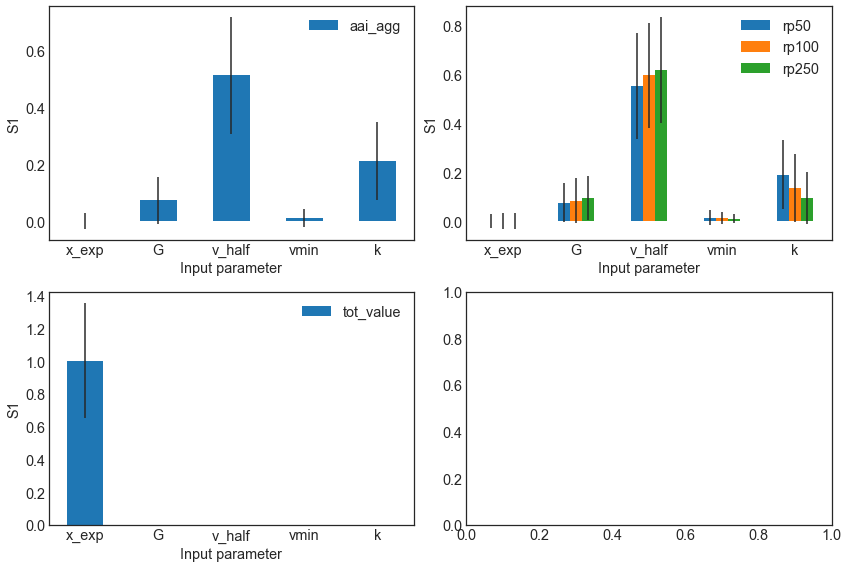

In [19]:
# Default for 'sobol' is to plot 'S1' sensitivity index.
output_imp.plot_sensitivity(figsize=(12,8));

Note that since we have quite a few measures, the imp_meas_fut and imp_meas_pres plots are too crowded. We can select only the other metrics easily. In addition, instead of showing first order sensitivity 'S1', we can plot the total sensitivity 'ST'.

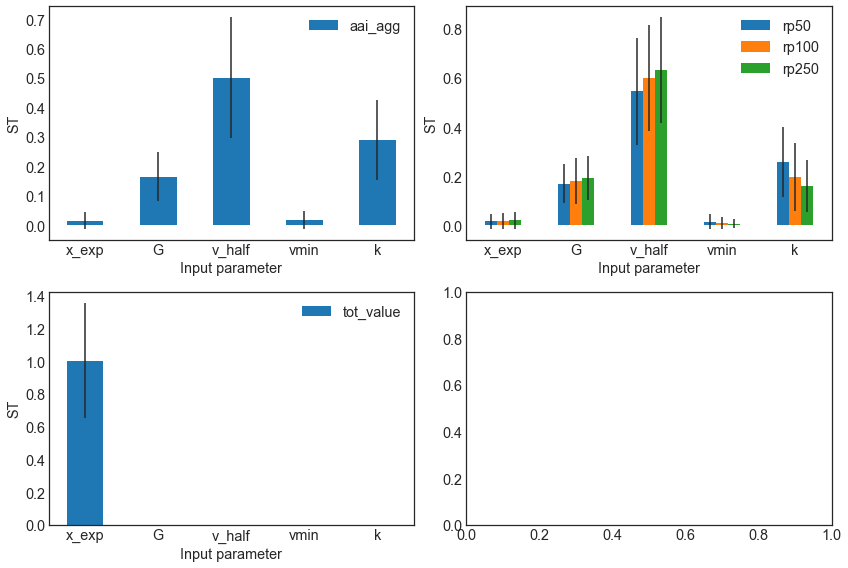

In [20]:
output_imp.plot_sensitivity(salib_si = 'ST', figsize=(12,8));

One can also vizualise the second-order sensitivity indices in the form of a correlation matrix.

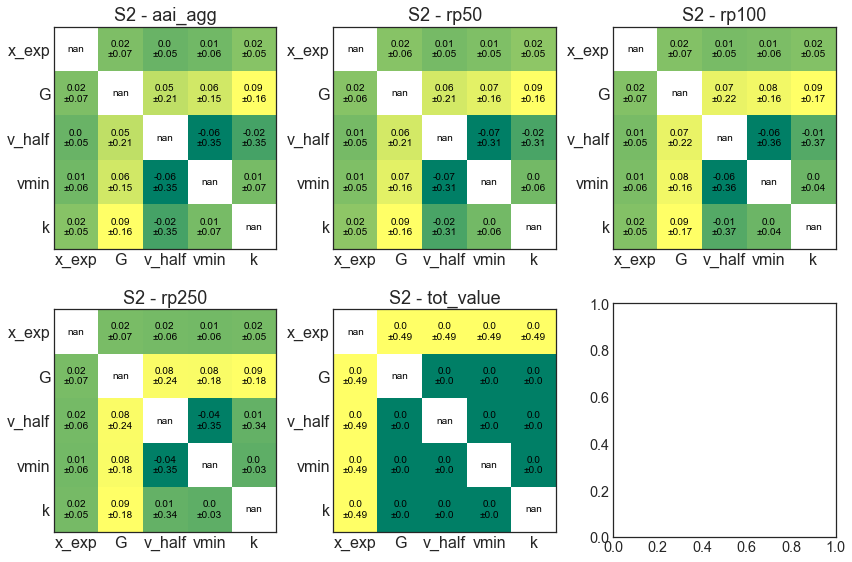

In [21]:
output_imp.plot_sensitivity_second_order(figsize=(12,8));

### A few non-default parameters

We shall use the same uncertainty variables as in the previous section but show a few possibilities to use non-default method arguments.

In [47]:
# Sampling method "latin" hypercube instead of `saltelli`.
from climada.engine.unsequa import CalcImpact

calc_imp2 = CalcImpact(exp_iv, impf_iv, haz)
output_imp2 = calc_imp2.make_sample(N=1000, sampling_method='latin')

2022-07-06 20:57:53,268 - climada.engine.unsequa.calc_base - INFO - Effective number of made samples: 1000


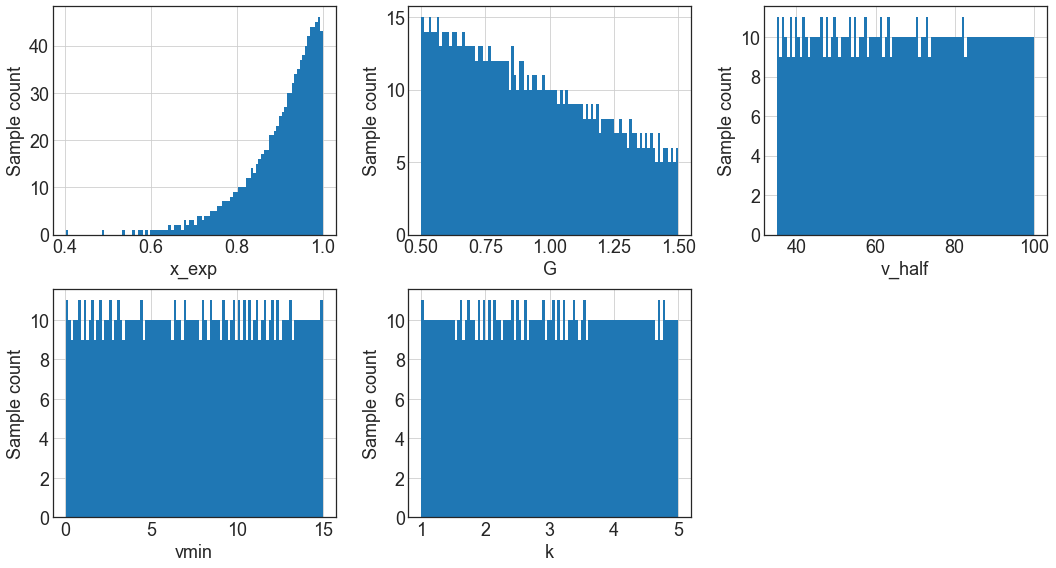

In [48]:
output_imp2.plot_sample(figsize=(15,8));

In [25]:
# Compute also the distribution of the metric `eai_exp`
# To speed-up the comutations, we use a ProcessPool for parallel computations
from pathos.pools import ProcessPool as Pool
import time

calc_imp2 = CalcImpact(exp_iv, impf_iv, haz)
output_imp2 = calc_imp2.make_sample(N=1000, sampling_method='latin')

start = time.time()
pool = Pool()
output_imp2 = calc_imp2.uncertainty(output_imp2, rp = [50, 100, 250], calc_eai_exp=True, calc_at_event=True, pool=pool)
pool.close() #Do not forget to close your pool!
pool.join()
pool.clear()
end = time.time()
time_passed = end-start
print(f'Time passed with pool: {time_passed}')

2022-07-06 21:17:20,981 - climada.engine.unsequa.calc_base - INFO - Effective number of made samples: 1000
2022-07-06 21:17:21,033 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,036 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,038 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:21,044 - climada.engine.unsequa.calc_base - INFO - 

Estimated computaion time: 0:00:02.412500

2022-07-06 21:17:21,140 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,144 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21

2022-07-06 21:17:21,265 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:21,266 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,271 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:21,270 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,271 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,275 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,273 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2022-07-06 21:17:21,374 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,376 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,378 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,377 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,379 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:21,381 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:21,380 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:2

2022-07-06 21:17:21,441 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,441 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,443 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,444 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,444 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,445 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,448 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:21,447 -

2022-07-06 21:17:21,514 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:21,514 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:21,514 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,514 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,518 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,514 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
20

2022-07-06 21:17:21,574 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,574 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,577 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,577 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,577 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,578 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,578 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:21,581 -

2022-07-06 21:17:21,634 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,634 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,634 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,634 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,632 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,638 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:21,638 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:21,638 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:21,639 - c

2022-07-06 21:17:21,701 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,706 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:21,706 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,705 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,706 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,707 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,709 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,711 -

2022-07-06 21:17:21,766 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,776 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,776 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,780 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,784 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,784 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17

2022-07-06 21:17:21,841 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,842 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,844 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,836 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,847 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:21,847 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,847 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:2

2022-07-06 21:17:21,911 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:21,901 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,912 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,915 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,915 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:21,915 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
20

2022-07-06 21:17:21,978 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,978 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:21,978 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,982 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:21,982 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


2022-07-06 21:17:22,041 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,045 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,047 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,047 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,047 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,051 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,053 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:2

2022-07-06 21:17:22,131 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,131 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,135 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,135 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,136 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,136 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,139 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 

2022-07-06 21:17:22,196 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,203 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,203 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,203 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,208 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,208 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-0

2022-07-06 21:17:22,282 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,283 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,285 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,285 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,288 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,291 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,295 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:2

2022-07-06 21:17:22,371 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,371 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,372 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,372 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,372 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,375 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17

2022-07-06 21:17:22,434 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,433 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,435 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,430 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,445 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,445 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity 

2022-07-06 21:17:22,497 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,501 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,497 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,507 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,495 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,510 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,509 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2022-07-06 21:17:22,568 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,570 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,565 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,565 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,574 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,573 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
20

2022-07-06 21:17:22,639 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,641 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,640 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,643 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,646 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,646 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,646 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 

2022-07-06 21:17:22,705 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,707 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,706 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,707 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,707 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,709 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,712 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022

2022-07-06 21:17:22,774 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,776 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,775 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,779 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,779 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,783 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,783 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:2

2022-07-06 21:17:22,847 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,844 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,849 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,851 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,852 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,854 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,847 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022

2022-07-06 21:17:22,922 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,925 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,928 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,929 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,929 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:22,926 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
20

2022-07-06 21:17:22,996 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,997 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,999 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:22,995 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:22,998 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,003 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17

2022-07-06 21:17:23,087 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,088 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,092 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,093 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,083 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,089 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,093 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022

2022-07-06 21:17:23,190 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,194 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,196 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,196 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,185 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,195 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
20

2022-07-06 21:17:23,272 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,276 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,281 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,281 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,280 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,282 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. C

2022-07-06 21:17:23,348 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,346 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,349 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,354 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,355 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,354 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,361 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,360 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,

2022-07-06 21:17:23,444 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,448 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,448 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,455 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,455 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,456 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity 

2022-07-06 21:17:23,525 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,525 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,522 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,526 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,530 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,527 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,530 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,527 -

2022-07-06 21:17:23,597 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,598 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,601 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,605 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,604 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,605 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,610 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 

2022-07-06 21:17:23,679 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,678 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,678 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,680 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,684 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,684 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,684 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,684 -

2022-07-06 21:17:23,758 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,750 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,759 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,758 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,760 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,764 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17

2022-07-06 21:17:23,825 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,825 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,826 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,826 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,833 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,828 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,839 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022

2022-07-06 21:17:23,897 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,898 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,897 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,899 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,899 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,903 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,904 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,904 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,

2022-07-06 21:17:23,969 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:23,971 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,971 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,973 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,973 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,975 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:23,976 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:23,980 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21

2022-07-06 21:17:24,049 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,050 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,052 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,053 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,051 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,047 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. C

2022-07-06 21:17:24,121 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,121 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,128 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,130 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,129 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,134 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,135 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

2022-07-06 21:17:24,229 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,231 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,232 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,234 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,207 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,236 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,223 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 

2022-07-06 21:17:24,311 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,311 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,312 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,313 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,315 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,315 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,321 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,321 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,322 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,323 - cli

2022-07-06 21:17:24,401 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,406 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,410 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,409 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,412 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,412 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,412 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,414 - climad

2022-07-06 21:17:24,483 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,486 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,487 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,487 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,487 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,491 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,491 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,492 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,492 - climada.

2022-07-06 21:17:24,560 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,566 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,566 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,569 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,573 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,574 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,578 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022

2022-07-06 21:17:24,646 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,646 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,642 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,648 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,652 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,652 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,653 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:2

2022-07-06 21:17:24,717 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,717 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,722 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,722 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,722 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,722 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,723 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,725 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,736 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. 

2022-07-06 21:17:24,808 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,808 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,809 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,809 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,809 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,814 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
20

2022-07-06 21:17:24,888 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,887 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,892 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,895 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,894 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,894 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-0

2022-07-06 21:17:24,960 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,959 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,960 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:24,959 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,961 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:24,965 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:24,965 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:2

2022-07-06 21:17:25,027 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:25,027 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:25,032 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:25,032 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:25,034 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:25,033 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:25,034 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the or

2022-07-06 21:17:25,108 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:25,107 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:25,109 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:25,114 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:25,113 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:25,113 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17

2022-07-06 21:17:25,184 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:25,189 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:25,189 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:25,189 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:25,190 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:25,190 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:25,195 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:25,195 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:25,195 - c

2022-07-06 21:17:25,317 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:25,321 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:25,321 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:25,325 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:25,326 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:25,330 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:25,335 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider s

In [23]:
from climada.engine.unsequa import CalcImpact
import time

In [24]:
calc_imp2 = CalcImpact(exp_iv, impf_iv, haz)
output_imp2 = calc_imp2.make_sample(N=1000, sampling_method='latin')

start2 = time.time()
output_imp2 = calc_imp2.uncertainty(output_imp2, rp = [50, 100, 250], calc_eai_exp=True, calc_at_event=True)
end2 = time.time()
time_passed_nopool = end2-start2
print(f'Time passed without pool: {time_passed_nopool}')

2022-07-06 21:17:06,510 - climada.engine.unsequa.calc_base - INFO - Effective number of made samples: 1000
2022-07-06 21:17:06,515 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-07-06 21:17:06,517 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-07-06 21:17:06,518 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2022-07-06 21:17:06,522 - climada.engine.unsequa.calc_base - INFO - 

Estimated computaion time: 0:00:10.200000

Time passed without pool: 4.289993047714233


In [48]:
# Add the original value of the impacts (without uncertainty) to the uncertainty plot
from climada.engine import ImpactCalc
imp = ImpactCalc(exp_base, impf_func(), haz).impact(assign_centroids=False)
aai_agg_o = imp.aai_agg
freq_curve_o = imp.calc_freq_curve([50, 100, 250]).impact
orig_list = [aai_agg_o] + list(freq_curve_o) +[1]

2022-01-10 21:12:47,695 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-01-10 21:12:47,697 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-01-10 21:12:47,699 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.


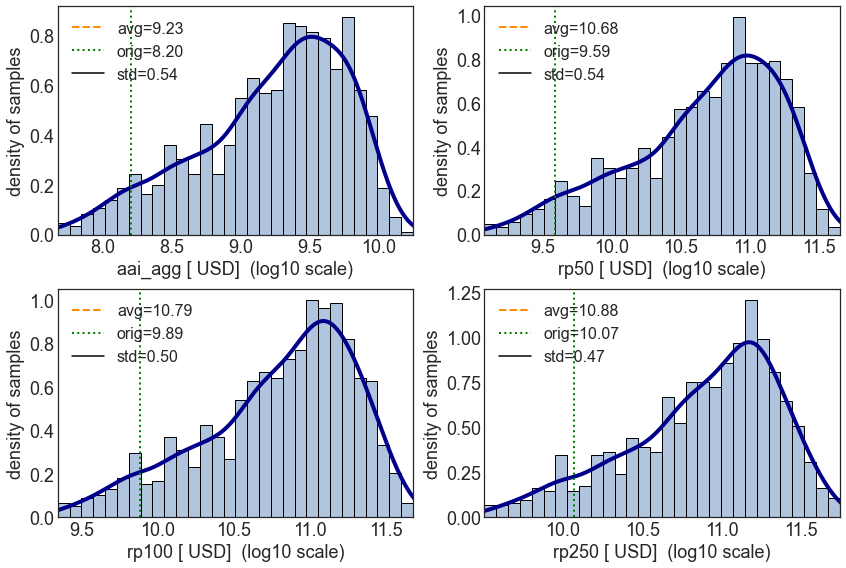

In [49]:
# plot the aai_agg and freq_curve uncertainty only
# use logarithmic x-scale
output_imp2.plot_uncertainty(metric_list=['aai_agg', 'freq_curve'], orig_list=orig_list, log=True, figsize=(12,8));

In [50]:
# Use the method 'rbd_fast' which is recommend in pair with 'latin'. In addition, change one of the kwargs 
# (M=15) of the salib sampling method.
output_imp2 = calc_imp2.sensitivity(output_imp2, sensitivity_method='rbd_fast', sensitivity_kwargs = {'M': 15})

/Users/ckropf/opt/anaconda3/envs/climada_310/lib/python3.8/site-packages/SALib/analyze/rbd_fast.py:106: RuntimeWarning: invalid value encountered in double_scalars
  return D1 / V


Since we computed the distribution and sensitivity indices for the total impact at each exposure point, we can plot a map of the largest sensitivity index in each exposure location. For every location, the most sensitive parameter is `v_half`, meaning that the average annual impact at each location is most sensitivity to the ucnertainty in the impact function slope scaling parameter.

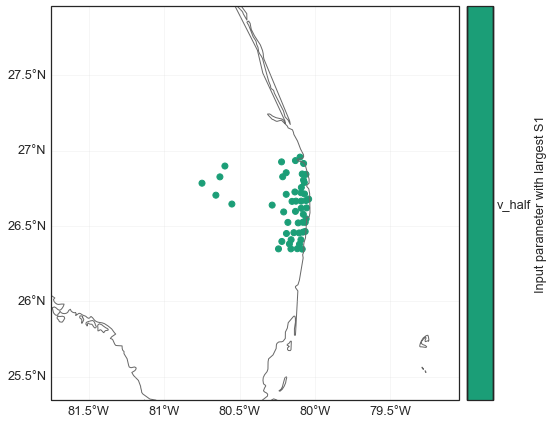

In [51]:
output_imp2.plot_sensitivity_map();

In [52]:
output_imp2.get_largest_si(salib_si='S1', metric_list=['eai_exp']).tail()

,metric,param,param2,si
45,45,v_half,None,0.479974
46,46,v_half,None,0.479974
47,47,v_half,None,0.479974
48,48,v_half,None,0.475221
49,49,v_half,None,0.479974


## CalcCostBenefit

The uncertainty and sensitivity analysis for CostBenefit is completely analogous to the Impact case. It is slightly more complex as there are more input variables.

### Set the InputVars 

In [53]:
import copy
from climada.util.constants import ENT_DEMO_TODAY, ENT_DEMO_FUTURE, HAZ_DEMO_H5
from climada.entity import Entity
from climada.hazard import Hazard

# Entity today has an uncertainty in the total asset value
def ent_today_func(x_ent):
    #In-function imports needed only for parallel computing on Windows
    from climada.entity import Entity 
    from climada.util.constants import ENT_DEMO_TODAY 
    entity = Entity.from_excel(ENT_DEMO_TODAY)
    entity.exposures.ref_year = 2018
    entity.exposures.gdf.value *= x_ent
    return entity

# Entity in the future has a +- 10% uncertainty in the cost of all the adapatation measures
def ent_fut_func(m_fut_cost):
    #In-function imports needed only for parallel computing on Windows
    from climada.entity import Entity 
    from climada.util.constants import ENT_DEMO_FUTURE 
    entity = Entity.from_excel(ENT_DEMO_FUTURE)
    entity.exposures.ref_year = 2040  
    for meas in entity.measures.get_measure('TC'):
        meas.cost *= m_fut_cost
    return entity

haz_base = Hazard.from_hdf5(HAZ_DEMO_H5)
# The hazard intensity in the future is also uncertainty by a multiplicative factor
def haz_fut(x_haz_fut, haz_base):
    #In-function imports needed only for parallel computing on Windows
    import copy 
    from climada.hazard import Hazard 
    from climada.util.constants import HAZ_DEMO_H5 
    haz = copy.deepcopy(haz_base)
    haz.intensity = haz.intensity.multiply(x_haz_fut)
    return haz
from functools import partial
haz_fut_func = partial(haz_fut, haz_base=haz_base)


2022-01-10 21:12:58,058 - climada.hazard.base - INFO - Reading /Users/ckropf/climada/demo/data/tc_fl_1990_2004.h5


Check that costs for measures are changed as desired.

In [54]:
costs_1 = [meas.cost for meas in ent_fut_func(1).measures.get_measure('TC')]
costs_05 = [meas.cost for meas in ent_fut_func(0.5).measures.get_measure('TC')]
print(f"\nThe cost for m_fut_cost=1 are {costs_1}\n"
     f"The cost for m_fut_cost=0.5 are {costs_05}");


The cost for m_fut_cost=1 are [1311768360.8515418, 1728000000.0, 8878779433.630093, 9200000000.0]
The cost for m_fut_cost=0.5 are [655884180.4257709, 864000000.0, 4439389716.815046, 4600000000.0]


/Users/ckropf/opt/anaconda3/envs/climada_310/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Define the InputVars

In [55]:
import scipy as sp
from climada.engine.unsequa import InputVar

haz_today = haz_base

haz_fut_distr = {"x_haz_fut": sp.stats.uniform(1, 3),
              }
haz_fut_iv = InputVar(haz_fut_func, haz_fut_distr)

ent_today_distr = {"x_ent":  sp.stats.uniform(0.7, 1)}
ent_today_iv = InputVar(ent_today_func, ent_today_distr)

ent_fut_distr = {"m_fut_cost":  sp.stats.norm(1, 0.1)}
ent_fut_iv = InputVar(ent_fut_func, ent_fut_distr)

In [56]:
ent_avg = ent_today_iv.evaluate()
ent_avg.exposures.gdf.head()

,latitude,longitude,value,deductible,cover,impf_TC,Value_2010
0,26.933899,-80.128799,1.671301e+10,0,1.392750e+10,1,5.139301e+09
1,26.957203,-80.098284,1.511528e+10,0,1.259606e+10,1,4.647994e+09
2,26.783846,-80.748947,1.511528e+10,0,1.259606e+10,1,4.647994e+09
3,26.645524,-80.550704,1.511528e+10,0,1.259606e+10,1,4.647994e+09
4,26.897796,-80.596929,1.511528e+10,0,1.259606e+10,1,4.647994e+09


### Compute cost benefit uncertainty and sensitivity using default methods 

For examples of how to use non-defaults please see the [impact example](###Compute-uncertainty-and-sensitivity-using-default-methods )

In [57]:
from climada.engine.unsequa import CalcCostBenefit

unc_cb = CalcCostBenefit(haz_input_var=haz_today, ent_input_var=ent_today_iv,
                     haz_fut_input_var=haz_fut_iv, ent_fut_input_var=ent_fut_iv)

In [58]:
output_cb= unc_cb.make_sample(N=10, sampling_kwargs={'calc_second_order':False})
output_cb.get_samples_df().tail()

2022-01-10 21:13:07,531 - climada.engine.unsequa.calc_base - INFO - Effective number of made samples: 50


,x_ent,x_haz_fut,m_fut_cost
45,1.263477,3.071289,1.012517
46,1.658008,3.071289,1.012517
47,1.263477,1.372070,1.012517
48,1.263477,3.071289,1.067757
49,1.658008,1.372070,1.067757


For longer computations, it is possible to use a pool for parallel computation.

In [68]:
from pathos.pools import ProcessPool as Pool

#without pool
output_cb = unc_cb.uncertainty(output_cb)

#with pool
#pool = Pool()
#output_cb = unc_cb.uncertainty(output_cb, pool=pool)
#pool.close() #Do not forget to close your pool!
#pool.join()
#pool.clear()
#If you have issues with the pool in jupyter, please restart the kernel or use without pool.

The output of `CostBenefit.calc` is rather complex in its structure. The metrics dictionary inherits this complexity.

In [60]:
#Top level metrics keys
macro_metrics = output_cb.uncertainty_metrics
macro_metrics

['imp_meas_present',
 'imp_meas_future',
 'tot_climate_risk',
 'benefit',
 'cost_ben_ratio']

In [61]:
# The benefits and cost_ben_ratio are available for each measure
output_cb.get_uncertainty(metric_list=['benefit', 'cost_ben_ratio']).tail()

,Mangroves Benef,Beach nourishment Benef,Seawall Benef,Building code Benef,Mangroves CostBen,Beach nourishment CostBen,Seawall CostBen,Building code CostBen
45,8.814039e+09,6.914137e+09,7.514788e+08,4.050774e+10,0.150690,0.253051,11.962963,0.229960
46,8.966634e+09,7.038734e+09,7.514788e+08,4.058393e+10,0.148126,0.248572,11.962963,0.229528
47,3.768293e+09,3.046279e+09,4.742905e+06,2.438938e+09,0.352464,0.574350,1895.444529,3.819348
48,8.814039e+09,6.914137e+09,7.514788e+08,4.050774e+10,0.158911,0.266857,12.615625,0.242506
49,3.920888e+09,3.170876e+09,4.742905e+06,2.515132e+09,0.357228,0.581884,1998.854177,3.905703


In [62]:
# The impact_meas_present and impact_meas_future provide values of the cost_meas, risk_transf, risk, 
# and cost_ins for each measure
output_cb.get_uncertainty(metric_list=['imp_meas_present']).tail()

,no measure - risk - present,no measure - risk_transf - present,no measure - cost_meas - present,no measure - cost_ins - present,Mangroves - risk - present,Mangroves - risk_transf - present,Mangroves - cost_meas - present,Mangroves - cost_ins - present,Beach nourishment - risk - present,Beach nourishment - risk_transf - present,Beach nourishment - cost_meas - present,Beach nourishment - cost_ins - present,Seawall - risk - present,Seawall - risk_transf - present,Seawall - cost_meas - present,Seawall - cost_ins - present,Building code - risk - present,Building code - risk_transf - present,Building code - cost_meas - present,Building code - cost_ins - present
45,9.696915e+07,0.0,0,0,4.841883e+07,0,1.311768e+09,1,5.732646e+07,0,1.728000e+09,1,9.696915e+07,0,8.878779e+09,1,7.272686e+07,0,9.200000e+09,1
46,1.272486e+08,0.0,0,0,6.353802e+07,0,1.311768e+09,1,7.522713e+07,0,1.728000e+09,1,1.272486e+08,0,8.878779e+09,1,9.543644e+07,0,9.200000e+09,1
47,9.696915e+07,0.0,0,0,4.841883e+07,0,1.311768e+09,1,5.732646e+07,0,1.728000e+09,1,9.696915e+07,0,8.878779e+09,1,7.272686e+07,0,9.200000e+09,1
48,9.696915e+07,0.0,0,0,4.841883e+07,0,1.311768e+09,1,5.732646e+07,0,1.728000e+09,1,9.696915e+07,0,8.878779e+09,1,7.272686e+07,0,9.200000e+09,1
49,1.272486e+08,0.0,0,0,6.353802e+07,0,1.311768e+09,1,7.522713e+07,0,1.728000e+09,1,1.272486e+08,0,8.878779e+09,1,9.543644e+07,0,9.200000e+09,1


We can plot the distributions for the top metrics or our choice.

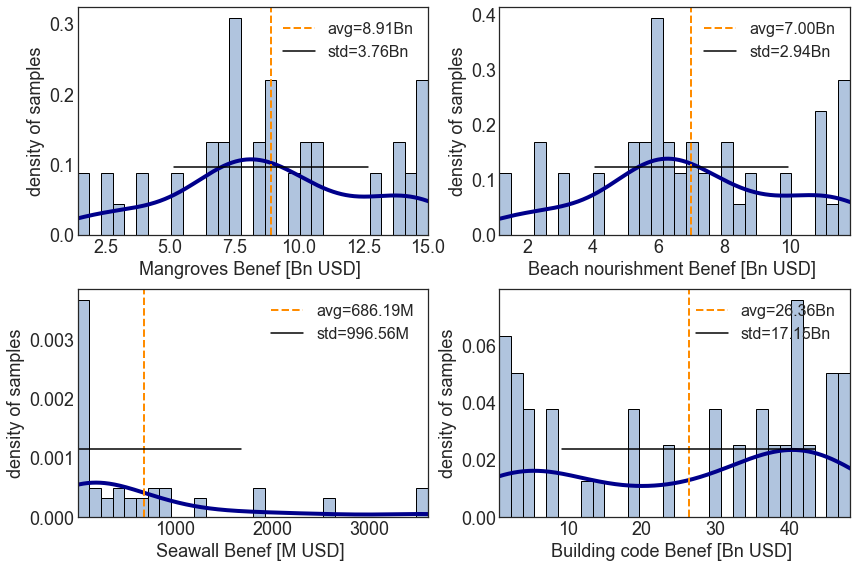

In [63]:
# tot_climate_risk and benefit
output_cb.plot_uncertainty(metric_list=['benefit'], figsize=(12,8));

Analogously to the impact example, now that we have a metric distribution, we can compute the sensitivity indices. Since we used the default sampling method, we can use the default sensitivity analysis method. However, since we used `calc_second_order = False` for the sampling, we need to specify the same for the sensitivity analysis.

In [64]:
output_cb = unc_cb.sensitivity(output_cb, sensitivity_kwargs={'calc_second_order':False})

/Users/ckropf/opt/anaconda3/envs/climada_310/lib/python3.8/site-packages/SALib/analyze/sobol.py:87: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()
/Users/ckropf/opt/anaconda3/envs/climada_310/lib/python3.8/site-packages/SALib/analyze/sobol.py:137: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_310/lib/python3.8/site-packages/SALib/analyze/sobol.py:137: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_310/lib/python3.8/site-packages/SALib/analyze/sobol.py:143: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_310/lib/python3.8/site-packages/SALib/analyze/sobol.py:143: RuntimeWarning: i

The sensitivity indices can be plotted. For the default method 'sobol', by default the 'S1' sensitivity index is plotted.

Note that since we have quite a few measures, the plot must be adjusted a bit or dropped. Also see that for many metrics, the sensitivity to certain uncertainty parameters appears to be 0. However, this result is to be treated with care. Indeed, we used for demonstration purposes a rather too low number of samples, which is indicated by large confidence intervals (vertical black lines) for most sensitivity indices. For a more robust result the analysis should be repeated with more samples.

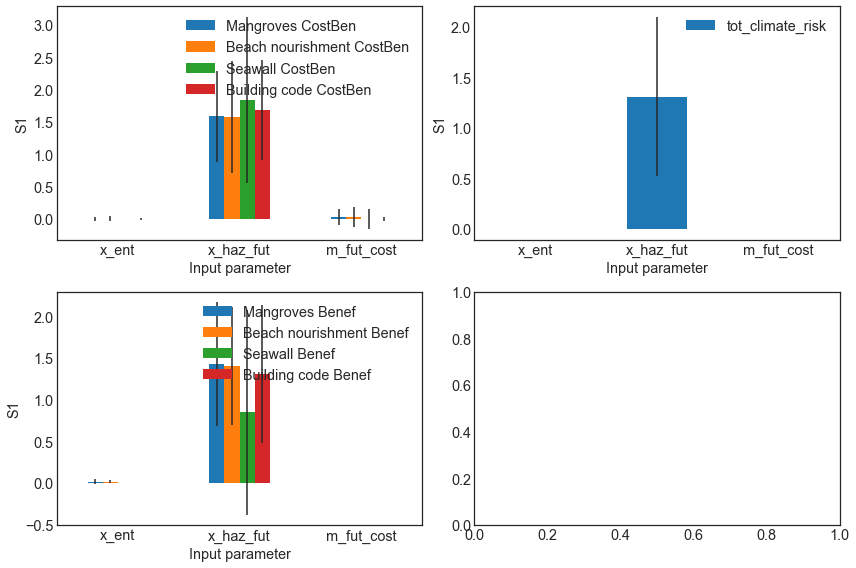

In [66]:
#plot only certain metrics
axes = output_cb.plot_sensitivity(metric_list=['cost_ben_ratio','tot_climate_risk','benefit'], figsize=(12,8));